<a href="https://colab.research.google.com/github/tlkt/fast_lesson_work/blob/master/lession_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/valid.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_08037.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f04860.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_04650.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0001TP_008100_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f01260_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_07350_P.png')]

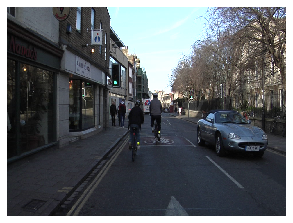

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

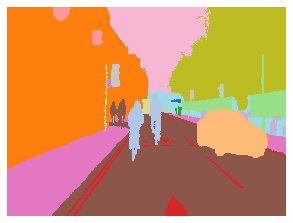

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5),alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [13]:
codes = np.loadtxt(path/'codes.txt',dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [0]:
size=src_size//2

bs=8

In [0]:
src = (SegmentationItemList.from_folder(path_img)
        .split_by_fname_file('../valid.txt')
        .label_from_func(get_y_fn,classes=codes))

In [0]:
data = (src.transform(get_transforms(),size=size,tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

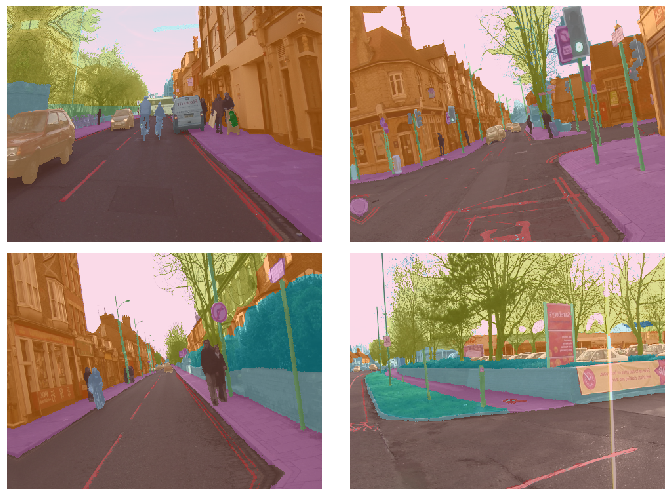

In [17]:
data.show_batch(rows=2,figsize=(10,7))

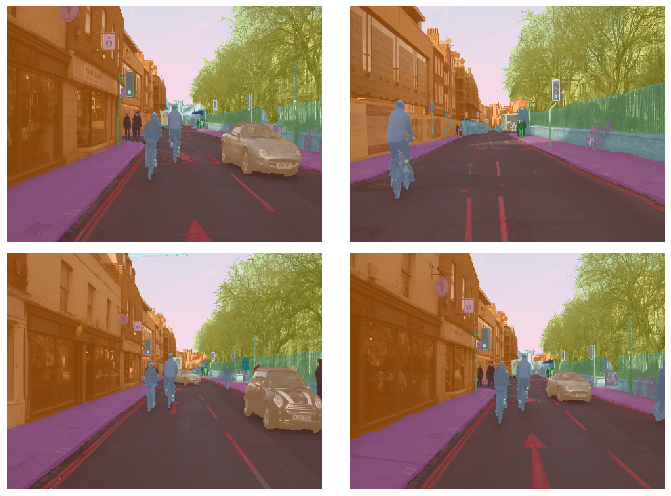

In [18]:
data.show_batch(rows=2,figsize=(10,7),ds_type=DatasetType.Valid)

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input,target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid

In [0]:
wd=1e-2

In [22]:
learn = unet_learner(data,models.resnet34,metrics=metrics,wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 57.9MB/s]


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


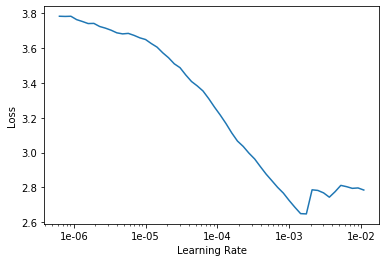

In [23]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 1e-4

In [25]:
learn.fit_one_cycle(10,slice(lr),pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.510205,2.017354,0.572597,00:58
1,1.671186,1.212328,0.741362,00:55
2,1.166917,0.875116,0.806427,00:55
3,0.921600,0.835541,0.791436,00:55
4,0.783739,0.797405,0.790863,00:56
5,0.700348,0.582893,0.841366,00:55
6,0.663444,0.489017,0.859306,00:55
7,0.569547,0.476785,0.865098,00:55
8,0.545100,0.495680,0.864286,00:55
9,0.479385,0.394589,0.886990,00:55


In [0]:
learn.save('stage-1')

In [27]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

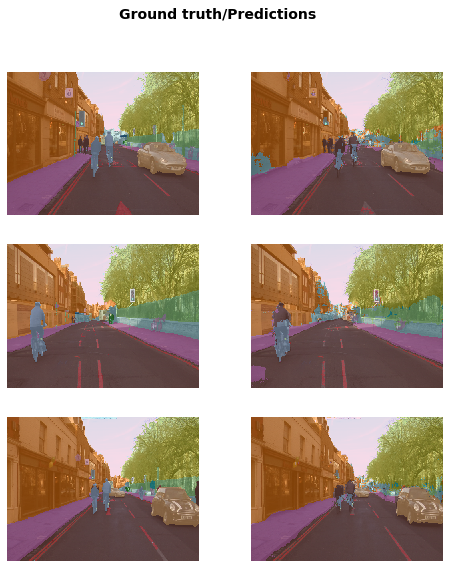

In [28]:
learn.show_results(rows=3,figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [31]:
learn.fit_one_cycle(12,lrs,pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.437564,0.383438,0.890877,00:57
1,0.434253,0.383295,0.890532,00:56
2,0.429252,0.371495,0.894577,00:57
3,0.425425,0.377488,0.891299,00:56
4,0.419709,0.370153,0.894099,00:56
5,0.423974,0.363625,0.898181,00:56
6,0.413127,0.362560,0.896844,00:56
7,0.414619,0.381178,0.890089,00:56
8,0.401106,0.381605,0.891917,00:56
9,0.387929,0.351114,0.900525,00:55


In [0]:
learn.save('stage-2')

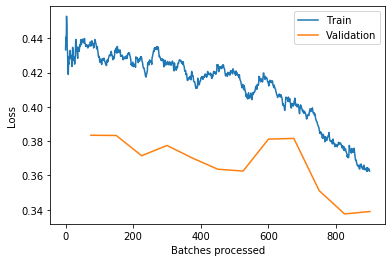

In [33]:
learn.recorder.plot_losses()

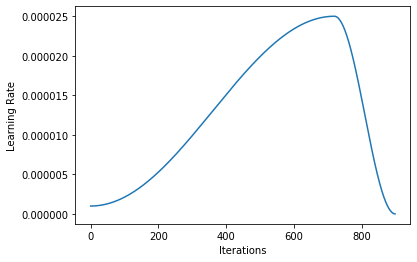

In [34]:
learn.recorder.plot_lr()

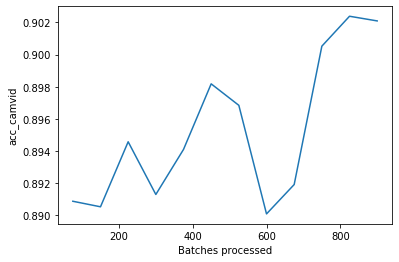

In [36]:
learn.recorder.plot_metrics()

In [37]:
doc(learn.recorder.plot_metrics)

In [47]:
learn.destroy()
size - src_size/1
bs=8

this object has been destroyed


In [0]:
data = (src.transform(get_transforms(),size=size,tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data,models.resnet34,metrics=metrics,wd=wd)

In [0]:
learn.save('stage-2')

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


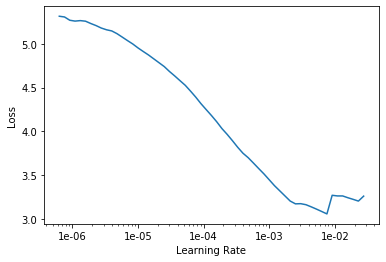

In [51]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-2

In [53]:
learn.fit_one_cycle(10,slice(lr/10),pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.082739,0.844793,0.806613,00:55
1,0.852498,0.654988,0.831581,00:55
2,0.721035,0.584227,0.841588,00:55
3,0.639499,0.537511,0.849489,00:55
4,0.604602,0.569525,0.845384,00:55
5,0.563878,0.453647,0.865816,00:55
6,0.558611,0.408066,0.871162,00:55
7,0.509032,0.421931,0.883129,00:55
8,0.518565,0.414976,0.878746,00:55
9,0.413751,0.325607,0.907087,00:55


In [0]:
learn.save('stage-2-big')

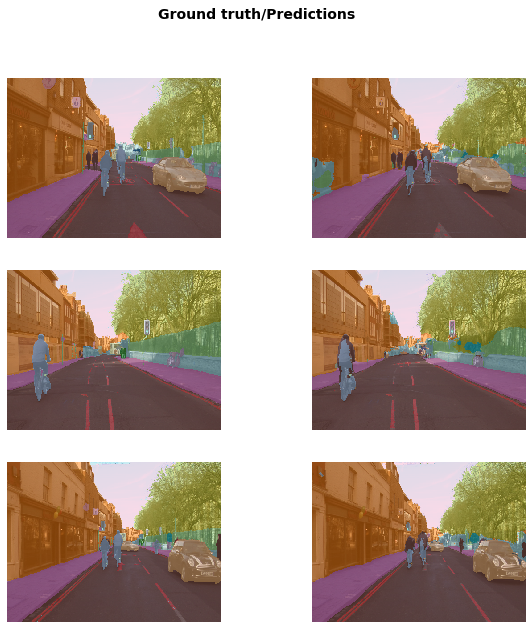

In [55]:
learn.show_results(rows=3,figsize=(10,10))